In [1]:
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import set_option
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,Normalizer,PowerTransformer,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import GridSearchCV

In [2]:
data = read_csv("oil-spill.csv",header=None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1,2558,1506.09,456.63,90,6395000.0,40.88,7.89,29780.0,0.19,...,2850.00,1000.00,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,2,22325,79.11,841.03,180,55812500.0,51.11,1.21,61900.0,0.02,...,5750.00,11500.00,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,3,115,1449.85,608.43,88,287500.0,40.42,7.34,3340.0,0.18,...,1400.00,250.00,150.00,45.13,9.33,1,31692.84,65.81,7.84,1
3,4,1201,1562.53,295.65,66,3002500.0,42.40,7.97,18030.0,0.19,...,6041.52,761.58,453.21,144.97,13.33,1,37696.21,65.67,8.07,1
4,5,312,950.27,440.86,37,780000.0,41.43,7.03,3350.0,0.17,...,1320.04,710.63,512.54,109.16,2.58,0,29038.17,65.66,7.35,0


ANALYZING DATASET

In [4]:
print(data.shape)

(937, 50)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       937 non-null    int64  
 1   1       937 non-null    int64  
 2   2       937 non-null    float64
 3   3       937 non-null    float64
 4   4       937 non-null    int64  
 5   5       937 non-null    float64
 6   6       937 non-null    float64
 7   7       937 non-null    float64
 8   8       937 non-null    float64
 9   9       937 non-null    float64
 10  10      937 non-null    float64
 11  11      937 non-null    float64
 12  12      937 non-null    float64
 13  13      937 non-null    float64
 14  14      937 non-null    float64
 15  15      937 non-null    float64
 16  16      937 non-null    float64
 17  17      937 non-null    float64
 18  18      937 non-null    float64
 19  19      937 non-null    float64
 20  20      937 non-null    float64
 21  21      937 non-null    float64
 22  22

1. As we can see that there is no missing value in the dataset.
2. There are only numeric attributes in the dataset.

# UNIMODAL DATA VISUALIZATIONS

In [6]:
print(data.groupby(49).size())

49
0    896
1     41
dtype: int64


In [7]:
target = data.values[:,-1]
counter = Counter(target)
for i,j in counter.items():
    per = j/len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (i, j, per))

Class=1, Count=41, Percentage=4.376%
Class=0, Count=896, Percentage=95.624%


Clearly here in this dataset positive class(cases of oil spillage) are very less as compared to the negative class. Therefore, this is clearly the problem of the imbalanced dataset.

In [8]:
set_option('display.max_columns',50)
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
count,937.000000,937.000000,937.000000,937.000000,937.000000,9.370000e+02,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.0,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000
mean,81.588047,332.842049,698.707086,870.992209,84.121665,7.696964e+05,43.242721,9.127887,3940.712914,0.221003,109.892743,0.251441,0.311217,0.484664,0.182892,0.301932,77.412561,31.151921,0.909039,0.228815,0.289317,76.085624,0.0,0.642177,559.910694,0.578292,7.498196,0.608399,4.271110,-2.828420,-0.428869,1.824589,0.002785,1.821793,43.086446,2432.689434,0.006894,31.241857,91.189968,60.547492,933.928677,427.565582,255.435902,106.112519,5.014002,0.128068,7985.718004,61.694386,8.119723,0.043757
std,64.976730,1931.938570,599.965577,522.799325,45.361771,3.831151e+06,12.718404,3.588878,8167.427625,0.090316,61.460846,0.088132,0.121386,0.216859,0.082943,0.204695,304.329842,152.693334,0.675492,0.075410,0.105366,22.937473,0.0,0.299945,612.459280,0.702157,3.967966,0.845222,3.619406,1.621832,0.215617,0.638722,0.048988,0.643398,95.167329,5219.377585,0.005337,31.584838,21.984410,13.838898,1001.681331,715.391648,534.306194,135.617708,5.029151,0.334344,6854.504915,10.412807,2.908895,0.204662
min,1.000000,10.000000,1.920000,1.000000,0.000000,7.031200e+04,21.240000,0.830000,667.000000,0.020000,41.000000,0.020000,0.030000,0.050000,0.010000,0.010000,4.820000,1.960000,0.130000,0.020000,0.020000,47.660000,0.0,0.170000,132.780000,-0.710000,2.960000,-1.790000,1.440000,-7.810000,-1.370000,0.000000,0.000000,0.000000,3.000000,360.000000,0.000000,5.050000,64.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2051.500000,35.950000,5.810000,0.000000
25%,31.000000,20.000000,85.270000,444.200000,54.000000,1.250000e+05,33.650000,6.750000,1371.000000,0.160000,83.500000,0.200000,0.240000,0.330000,0.130000,0.130000,21.090000,11.680000,0.370000,0.180000,0.230000,55.850000,0.0,0.450000,221.970000,0.180000,4.660000,0.090000,2.640000,-3.250000,-0.530000,1.220000,0.000000,1.210000,12.000000,720.000000,0.000000,13.450000,78.000000,50.000000,450.000000,180.000000,90.800000,50.120000,2.370000,0.000000,3760.570000,65.720000,6.340000,0.000000
50%,64.000000,65.000000,704.370000,761.280000,73.000000,1.863000e+05,39.970000,8.200000,2090.000000,0.200000,99.800000,0.240000,0.290000,0.430000,0.170000,0.270000,34.720000,16.490000,0.700000,0.220000,0.270000,69.090000,0.0,0.500000,351.670000,0.870000,5.070000,0.480000,3.330000,-2.780000,-0.380000,1.950000,0.000000,1.950000,23.000000,1350.000000,0.010000,23.630000,82.000000,55.000000,685.420000,270.000000,161.650000,73.850000,3.850000,0.000000,5509.430000,65.930000,7.220000,0.000000
75%,124.000000,132.000000,1223.480000,1260.370000,117.000000,3.304680e+05,52.420000,10.760000,3435.000000,0.260000,115.400000,0.290000,0.350000,0.610000,0.220000,0.410000,65.950000,24.750000,1.060000,0.270000,0.320000,85.220000,0.0,0.960000,422.120000,1.010000,12.060000,0.980000,4.500000,-1.620000,-0.280000,2.170000,0.000000,2.170000,39.000000,2160.000000,0.010000,37.760000,99.000000,67.000000,1053.420000,460.980000,265.510000,125.810000,6.320000,0.000000,9521.930000,66.130000,7.840000,0.000000
max,352.000000,32389.000000,1893.080000,2724.570000,180.000000,7.131500e+07,82.640000,24.690000,160740.000000,0.740000,901.700000,0.660000,0.830000,1.230000,0.650000,1.120000,6058.230000,4061.150000,2.600000,0.650000,0.770000,126.080000,0.0,1.330000,2036.800000,1.830000,14.780000,5.720000,39.420000,1.280000,0.000000,2.980000,0.870000,2.980000,1695.000000,95310.00000

Here we can see the scale of attributes are not same.

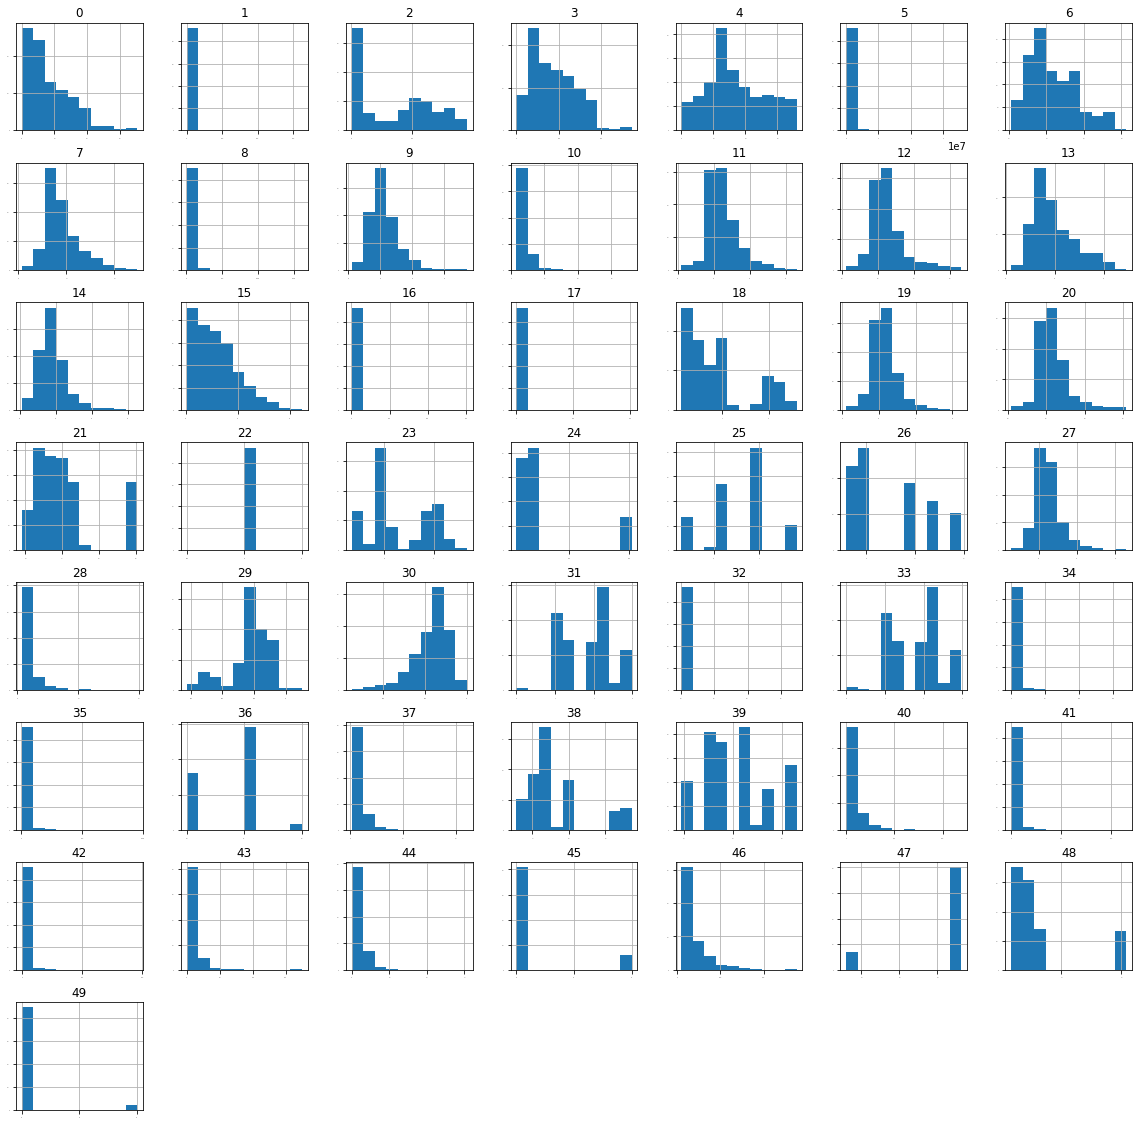

In [9]:
#Let's plot the histogram for the distribution.
data.hist(figsize=(20,20),sharex=False,sharey=False,xlabelsize=1,ylabelsize=1)
plt.show()

Here the bars which are to the left represents that the values lie between 0 and 1 but other than that it represents the single value in the column like that of column 22.

In [10]:
#confirming'
data[22].value_counts()

0    937
Name: 22, dtype: int64

which confirms that this column only contains a single value thus can be dropped. Also column 0 represents the image patch number which is not useful in modelling therefore this can also be discarded.

In [11]:
#dropping the unnecessary columns
data.drop(22,axis=1,inplace=True)
data.drop(0,axis=1,inplace=True)

In [12]:
#Splitting the dataset
data = data.values
X = data[:,:-1]
Y = data[:,-1]

In [13]:
Y = LabelEncoder().fit_transform(Y)

# Dimensionality reduction

Feature 0: 1.090291
Feature 1: 1.161358
Feature 2: 2.389564
Feature 3: 5.811941
Feature 4: 2.279728
Feature 5: 0.641420
Feature 6: 0.194838
Feature 7: 5.529996
Feature 8: 0.166899
Feature 9: 23.811232
Feature 10: 0.317237
Feature 11: 1.222057
Feature 12: 1.815502
Feature 13: 0.061235
Feature 14: 2.391996
Feature 15: 0.209771
Feature 16: 0.036682
Feature 17: 0.466412
Feature 18: 2.337725
Feature 19: 0.284437
Feature 20: 1.168075
Feature 21: 1.525838
Feature 22: 0.163003
Feature 23: 2.800185
Feature 24: 4.366841
Feature 25: 3.512655
Feature 26: 0.429362
Feature 27: 2.392162
Feature 28: 1.631012
Feature 29: 0.162286
Feature 30: 0.138497
Feature 31: 0.183501
Feature 32: 2.029587
Feature 33: 1.555670
Feature 34: 9.524239
Feature 35: 1.643175
Feature 36: 1.067376
Feature 37: 4.118175
Feature 38: 21.225566
Feature 39: 2.405545
Feature 40: 2.028930
Feature 41: 0.913613
Feature 42: 0.247298
Feature 43: 3.214870
Feature 44: 220.566690
Feature 45: 0.009356
Feature 46: 0.065431


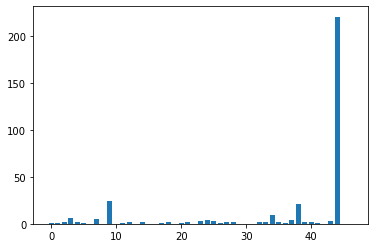

In [14]:
#Feature Selection using ANOVA
from sklearn.feature_selection import f_classif,SelectKBest
fs = SelectKBest(score_func = f_classif, k='all')
fs.fit(X,Y)
X_new = fs.transform(X)
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [15]:
#Using GridSearchCV for getting the best value of number of features
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3, random_state = 1)
model = LogisticRegression(solver='liblinear')
fs = SelectKBest(score_func = f_classif)
pipeline = Pipeline(steps=[('anova',fs),('lr',model)])
grid = dict()
grid['anova__k'] = [i+1 for i in range(X.shape[1])]
search = GridSearchCV(pipeline, grid, scoring='accuracy',n_jobs=-1,cv =cv)
results = search.fit(X,Y)
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

Best Mean Accuracy: 0.959
Best Config: {'anova__k': 16}


In [16]:
#Feature Selection using ANOVA
from sklearn.feature_selection import f_classif,SelectKBest
fs = SelectKBest(score_func = f_classif, k=16)
fs.fit(X,Y)
X_new = fs.transform(X)

In [17]:
print(fs.get_feature_names_out())

['x2' 'x3' 'x7' 'x9' 'x14' 'x18' 'x23' 'x24' 'x25' 'x27' 'x34' 'x37' 'x38'
 'x39' 'x43' 'x44']


# Creating a test harness

In [18]:
def evaluate_model(X, Y, model):
    # evaluation_procedure
    cross_v = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(geometric_mean_score)
    #evaluate model
    scores = cross_val_score(model, X, Y, scoring= metric, cv=cross_v, n_jobs=-1)
    return scores

In [19]:
model = DummyClassifier(strategy='uniform')
#evaluating the model
scores = evaluate_model(X_new, Y, model)
print("Mean G-Mean: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

Mean G-Mean: 0.515 (0.121)


Now we a have baseline evaluation score. 

In [20]:
def get_models():
    models, names = list(), list()
    #LR
    steps = [('t',StandardScaler()),('m',LogisticRegression(solver='liblinear'))]
    models.append(Pipeline(steps=steps))
    names.append('LR')
    #LDA
    steps = [('t',StandardScaler()),('m',LinearDiscriminantAnalysis())]
    models.append(Pipeline(steps=steps))
    names.append('LDA')
    #NB
    models.append(GaussianNB())
    names.append('NB')
    return models, names

In [21]:
models,names = get_models()
results=[]
for i in range(len(models)):
    #evaluating the model and storing the result
    scores = evaluate_model(X_new,Y,models[i])
    results.append(scores)
    #summarize
    print(">%s %.3f (%.3f)" % (names[i], np.mean(scores), np.std(scores)))

>LR 0.436 (0.330)
>LDA 0.631 (0.264)
>NB 0.668 (0.203)


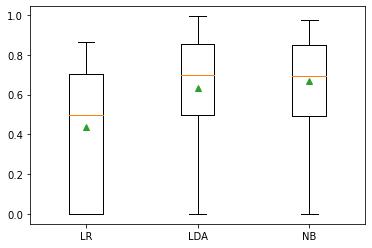

In [22]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [23]:
#LDA SEEMS TO HAVE PERFORMING BEST.

Analyzing the dataset and then having seen the baseline performance of various algorithm we can try to improve the performance by applying various steps:
1. Since the dataset is imbalanced, we can use LogisticRegression's parameter class_weight to 'balanced' which adjusts the importance of classification errors to be inversely proportional to the class weighting.
2. Also, since Logistic Regression is sensitive to the scale of the input variables, we will normalize or standardize the input variables.
3. As Logistic Regression make assumptions about the distribution of the input variables, we will power transform them to make those variables with gaussian-like distribution more gaussian.

In [24]:
def get_models_bal():
    models, names = list(), list()
    # LR balanced
    model = LogisticRegression(solver='liblinear',class_weight='balanced')
    models.append(model)
    names.append('LR')
    
    # LR Balanced + Norm
    
    model = LogisticRegression(solver='liblinear',class_weight='balanced')
    steps = [('t', Normalizer()), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('Norm+balLR')
    
    # LR Balanced + Std
    
    model = LogisticRegression(solver='liblinear',class_weight='balanced')
    steps = [('t', StandardScaler()), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('Std+balLR')
    
    # LR Balanced + Power
    
    model = LogisticRegression(solver='liblinear',class_weight='balanced')
    steps = [('t1',Normalizer()), ('t2', PowerTransformer()),('m',
            model)]
    models.append(Pipeline(steps=steps))
    names.append('Norm+Pow+balLR')
    return models, names

In [25]:
models,names = get_models_bal()
results=[]
for i in range(len(models)):
    #evaluating the model and storing the result
    scores = evaluate_model(X_new,Y,models[i])
    results.append(scores)
    #summarize
    print(">%s %.3f (%.3f)" % (names[i], np.mean(scores), np.std(scores)))

>LR 0.810 (0.126)
>Norm+balLR 0.776 (0.126)
>Std+balLR 0.805 (0.122)
>Norm+Pow+balLR 0.844 (0.103)


This is great improvement on the previous model.

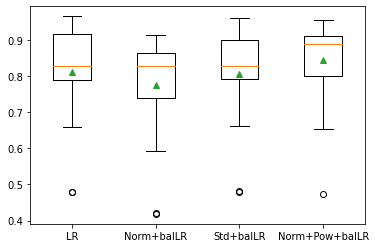

In [26]:
plt.boxplot(results,labels=names, showmeans=True)
plt.show()

Now we will use the oversampling technique SMOTE to create the artificial samples for the minority class and use it along with the ENN to delete some of the doubtful samples for both the class.
As SMOTE and ENN both are distance based algorithm we need scaled input data.
As we saw that Normalizer+PowerTransform+LogisticRegression gave us the accuracy of 85% we will use SMOTEENN along with these steps only.

In [27]:
sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_res, Y_res = sampling.fit_resample(X_new,Y)

#define models to test
def get_models_smote():
    models, names = list(), list()
    # SMOTEENN
    model = LogisticRegression(solver='liblinear')
    models.append(model)
    names.append('S+LR')
    
    # SMOTEENN + Norm
    
    model = LogisticRegression(solver='liblinear')
    steps = [('t', Normalizer()), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('S+NORM+LR')
    
    # SMOTEENN + Std
    
    model = LogisticRegression(solver='liblinear')
    steps = [('t', StandardScaler()), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('S+STD+LR')
    
    # SMOTEENN + Power
    
    model = LogisticRegression(solver='liblinear')
    steps = [('t1', Normalizer()),('p',PowerTransformer(method='yeo-johnson')),('m',model)]
    models.append(Pipeline(steps=steps))
    names.append('S+Norm+Pow+LR')
    return models, names

In [28]:
models, names = get_models_smote()
results=[]
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X_res, Y_res, models[i])
    # summarize and store
    print('>%s ->  %.3f (%.3f)' % (names[i],np.mean(scores),np.std(scores)))
    results.append(scores)

>S+LR ->  0.899 (0.021)
>S+NORM+LR ->  0.854 (0.026)
>S+STD+LR ->  0.937 (0.017)
>S+Norm+Pow+LR ->  0.926 (0.021)


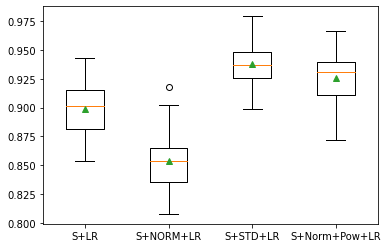

In [29]:
plt.boxplot(results,labels=names, showmeans=True)
plt.show()